In [34]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

In [1]:
# split into train and test set

from mrcnn.utils import Dataset
from matplotlib import pyplot

# class that defines and loads the kangaroo dataset
class PersonDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("dataset", 1, "person")
        # define data locations
        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'
        # find all images
        
        for filename in listdir(images_dir):
            # extract image id
            image_id = filename[:-4]
            num = image_id[7:]
            if(filename.find('person')==-1):
                continue
            # skip all images after 150 if we are building the train set
            if is_train and int(num) >= 197:
                continue
            # skip all images before 150 if we are building the test/val set
            if not is_train and int(num) < 197:
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.txt'
            # add to dataset
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
            

    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        # load and parse the file
        f = open(filename)
        text = f.read()
        text = text.split('\n')
        channels = text[3][-1]
        height = text[3][-7:-4]
        width = text[3][-13:-10]
        height = int(height)
        width = int(width)

        boxes = list()
        for line in text:
            if(line.find("Bounding box") != -1):
                index = line.find(':')
                labels = line[index+1:]

                #coors = [xmin, ymin, xmax, ymax]
                #boxes.append(coors)
                labels = labels.strip() 
                index = labels.find('-')
                min_labels = labels[:index-1]
                max_labels = labels[index+2:]

                comma = min_labels.find(',')
                xmin = min_labels[1:comma]
                ymin = min_labels[comma+2:-1]

                comma = max_labels.find(',')
                xmax = max_labels[1:comma]
                ymax = max_labels[comma+2:-1]

                xmin = int(xmin)
                ymin = int(ymin)
                xmax = int(xmax)
                ymax = int(ymax)
                coord = [xmin, ymin, xmax, ymax]
                boxes.append(coord)
        return boxes, width, height

    # load the masks for an image
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        # define box file location
        path = info['annotation']
        # load XML
        boxes, w, h = self.extract_boxes(path)
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('person'))
        return masks, asarray(class_ids, dtype='int32')

    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

# train set
train_set = PersonDataset()
train_set.load_dataset('person', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = PersonDataset()
test_set.load_dataset('person', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 135
Test: 32


(640, 480, 3)
(640, 480, 4)


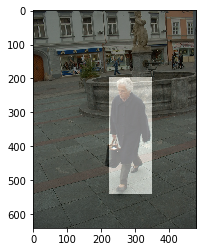

In [2]:
#training image check
image_id = 19
image = train_set.load_image(image_id)
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)
# plot image
pyplot.imshow(image)
# plot mask
pyplot.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
pyplot.show()

(480, 640, 3)
(480, 640, 1)


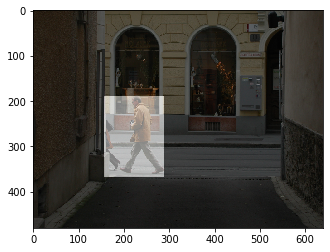

In [3]:
#training image check
image_id = 7
image = test_set.load_image(image_id)
print(image.shape)
# load image mask
mask, class_ids = test_set.load_mask(image_id)
print(mask.shape)
# plot image
pyplot.imshow(image)
# plot mask
pyplot.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
pyplot.show()

In [6]:
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
# define a configuration for the model
class PersonConfig(Config):
    # define the name of the configuration
    NAME = "person_model"
    # number of classes (background + person)
    NUM_CLASSES = 2
    # number of training steps per epoch
    STEPS_PER_EPOCH = 135

In [8]:
config = PersonConfig()
config.display()
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
# load weights (mscoco) and exclude the output layers
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/opt/anaconda3/lib/python3.7/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/5
135/135 [==============================] - 8397s 62s/step - loss: 0.8304 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1695 - mrcnn_class_loss: 0.0530 - mrcnn_bbox_loss: 0.2833 - mrcnn_mask_loss: 0.3179 - val_loss: 0.6968 - val_rpn_class_loss: 0.0069 - val_rpn_bbox_loss: 0.1929 - val_mrcnn_class_loss: 0.0722 - val_mrcnn_bbox_loss: 0.2018 - val_mrcnn_mask_loss: 0.2230

Epoch 2/5
135/135 [==============================] - 8160s 60s/step - loss: 0.6936 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.2840 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.1689 - mrcnn_mask_loss: 0.1870 - val_loss: 0.6514 - val_rpn_class_loss: 0.0088 - val_rpn_bbox_loss: 0.1903 - val_mrcnn_class_loss: 0.0656 - val_mrcnn_bbox_loss: 0.1977 - val_mrcnn_mask_loss: 0.1890
Epoch 3/5
135/135 [==============================] - 8150s 60s/step - loss: 0.4488 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1497 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.1029 - mrcnn_mask_loss: 0.1698 - val_loss: 0.6248 - val_rpn_c

In [11]:
#define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "person_cfg"
    # number of classes (background + person)
    NUM_CLASSES = 1 + 1
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
#calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = mean(APs)
    return mAP
 

cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model.load_weights('person_model20200731T0029/mask_rcnn_person_model_0005.h5', by_name=True)
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

Train mAP: 0.973
Test mAP: 0.935


In [29]:
from matplotlib.patches import Rectangle
def plot_predicted(image,yhat):
    pyplot.imshow(image)
    pyplot.title('Predicted')
    ax = pyplot.gca()
    # plot each box
    for box in yhat['rois']:
        # get coordinates
        y1, x1, y2, x2 = box
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='red')
        # draw the box
        ax.add_patch(rect)
        
def plot_actual(image,mask):
    pyplot.imshow(image)
    pyplot.title('Actual')
    # plot masks
    for j in range(mask.shape[2]):
        pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)

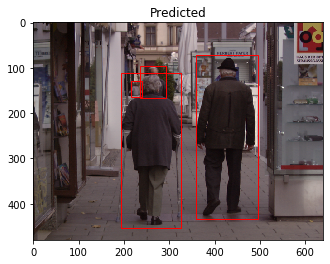

In [30]:
image_id = 10
image = test_set.load_image(image_id)
mask, _ = test_set.load_mask(image_id)
# convert pixel values (e.g. center)
scaled_image = mold_image(image, cfg)
# convert image into one sample
sample = expand_dims(scaled_image, 0)
# make prediction
yhat = model.detect(sample, verbose=0)[0]
plot_predicted(image,yhat)

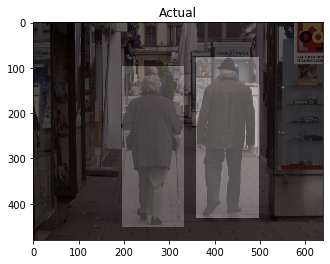

In [31]:
plot_actual(image,mask)

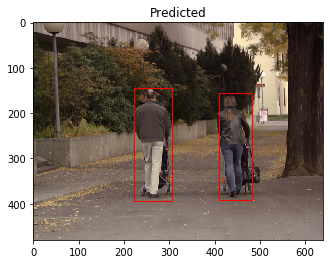

In [32]:
image_id = 11
image = test_set.load_image(image_id)
mask, _ = test_set.load_mask(image_id)
# convert pixel values (e.g. center)
scaled_image = mold_image(image, cfg)
# convert image into one sample
sample = expand_dims(scaled_image, 0)
# make prediction
yhat = model.detect(sample, verbose=0)[0]
plot_predicted(image,yhat)

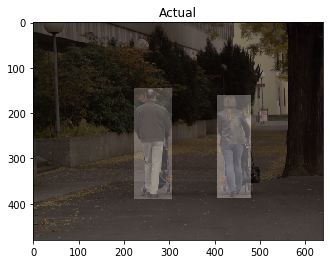

In [33]:
plot_actual(image,mask)